# CEE 690-02

# Environmental Spatial Data Analysis

# Dimensionality Reduction

# Dimensionality Reduction

# Curse of dimensionality 

* We want to use as much data (i.e., predictors) as we have to solve our problem (e.g., clustering or classification)
* The more dimensions we use, the more prone we are to overfitting or not finding a global optima.
* Interest in finding a sweet spot to maximize use of all data while minimizing information overload on predictive algorithms. 

# Can we simplify this mess?

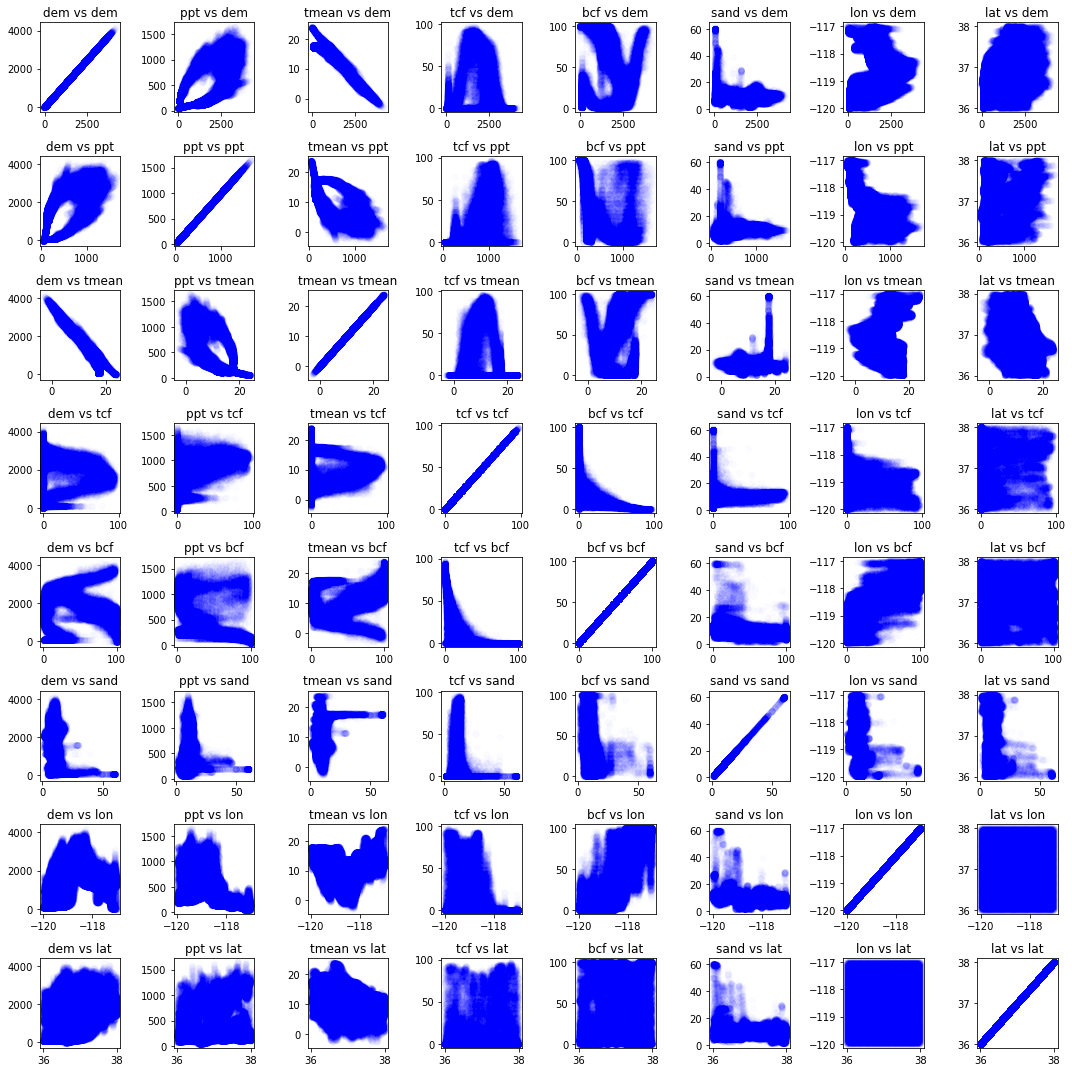

How could we reduce the number of features?

# Dimensionality reduction does not necessarily mean throwing out data

(Although one should always be careful what data they use)

# Principal Component Analysis

## Toy problem: Bivariate Gaussian

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Define mu vector
mu = np.array([0.0,0.0])
#Define covariance matrix
cov = np.array([[1.0,0.8],[0.8,1.0]])
#Draw samples from bivariate distribution
X = np.random.multivariate_normal(mu,cov,5000)

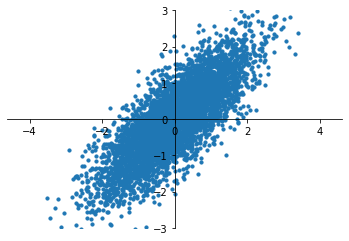

In [2]:
plt.scatter(X[:,0],X[:,1],s=10)
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

## What are the two directions of most variance?

# Scikit-learn magic

This is meant to be a motivation. We will dive into the details in a moment.

In [3]:
import sklearn.decomposition
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=2)
#Fit the model
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

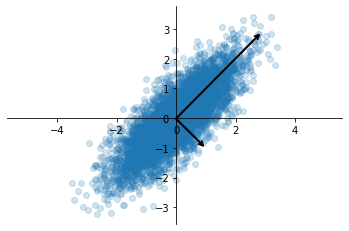

In [4]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.axis('equal');

## Transform our data to this new projection

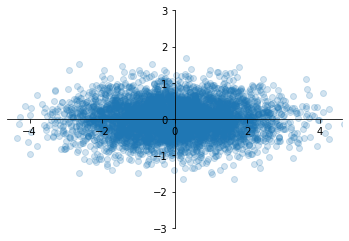

In [5]:
Y = pca.transform(X)
plt.scatter(Y[:,0],Y[:,1],alpha=0.2)
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# We could be done explaining PCA at this stage...

<img src="Images/PCAintro.gif">

Source: https://medium.com/bluekiri/understanding-principal-component-analysis-once-and-for-all-9f75e7b33635

But we really haven't explained anything...

# Tangent: Back to the concept of a covariance matrix

$$\mathbf{\Sigma} = \begin{bmatrix}
\sigma^2_{X_1}&\cdots&\text{cov}(X_1,X_n)\\
\vdots&\ddots&\vdots\\
\text{cov}(X_n,X_1)&\cdots&\sigma^2_{X_n}\\
\end{bmatrix}$$

Remember that $\mathbf{\Sigma}$ is used to represent the "population" covariance matrix. We will define the sample covariance matrix as $\mathbf{Q}$.

But aren't they the same thing? Rarely will $\mathbf{Q}$ exactly match $\mathbf{\Sigma}$. Let's show an example:

In [6]:
#Population covariance 
#Define mu vector
mu = np.array([0.0,0.0])
#Define covariance matrix
Sigma = np.array([[1.0,0.8],[0.8,1.0]])

In [7]:
#Draw samples from bivariate distribution
np.random.seed(1)
X = np.random.multivariate_normal(mu,Sigma,1000)

In [8]:
#Ensure the sample data is centered at 0
X = X - np.mean(X,axis=0)

In [9]:
#Transform the shape to ndim x nsamples
X = X.T

How do we construct the sample covariance matrix $\mathbf{Q}$ from $\mathbf{X}$?

$Q = \frac{1}{n-1}\mathbf{X}\mathbf{X^T}$ 

Note that here we assume that each column in $\mathbf{X}$ has been centered at 0 (i.e., the mean has been subtracted).

In [10]:

print('Dimensions:',X.shape)
n = X.shape[1] #number of samples
Q = 1/(n-1)*np.matmul(X,X.T)
print(Q)

Dimensions: (2, 1000)
[[0.99391729 0.81527057]
 [0.81527057 1.03964335]]


Compare the "true" covariance matrix $\mathbf{\Sigma}$ to the sample covariance matrix $\mathbf{Q}$.

In [11]:
print('Population covariance matrix:')
print(Sigma)
print('Sample covariance matrix')
print(Q)

Population covariance matrix:
[[1.  0.8]
 [0.8 1. ]]
Sample covariance matrix
[[0.99391729 0.81527057]
 [0.81527057 1.03964335]]


Note that numpy already has a function to compute the covariance matrix (it will already center the data for us).

In [12]:
Q = np.cov(X)
print(Q)

[[0.99391729 0.81527057]
 [0.81527057 1.03964335]]


**Back to PCA**: Harness the covariance matrix to project our data onto a new orthogonal basis.

# PCA: Building intuition

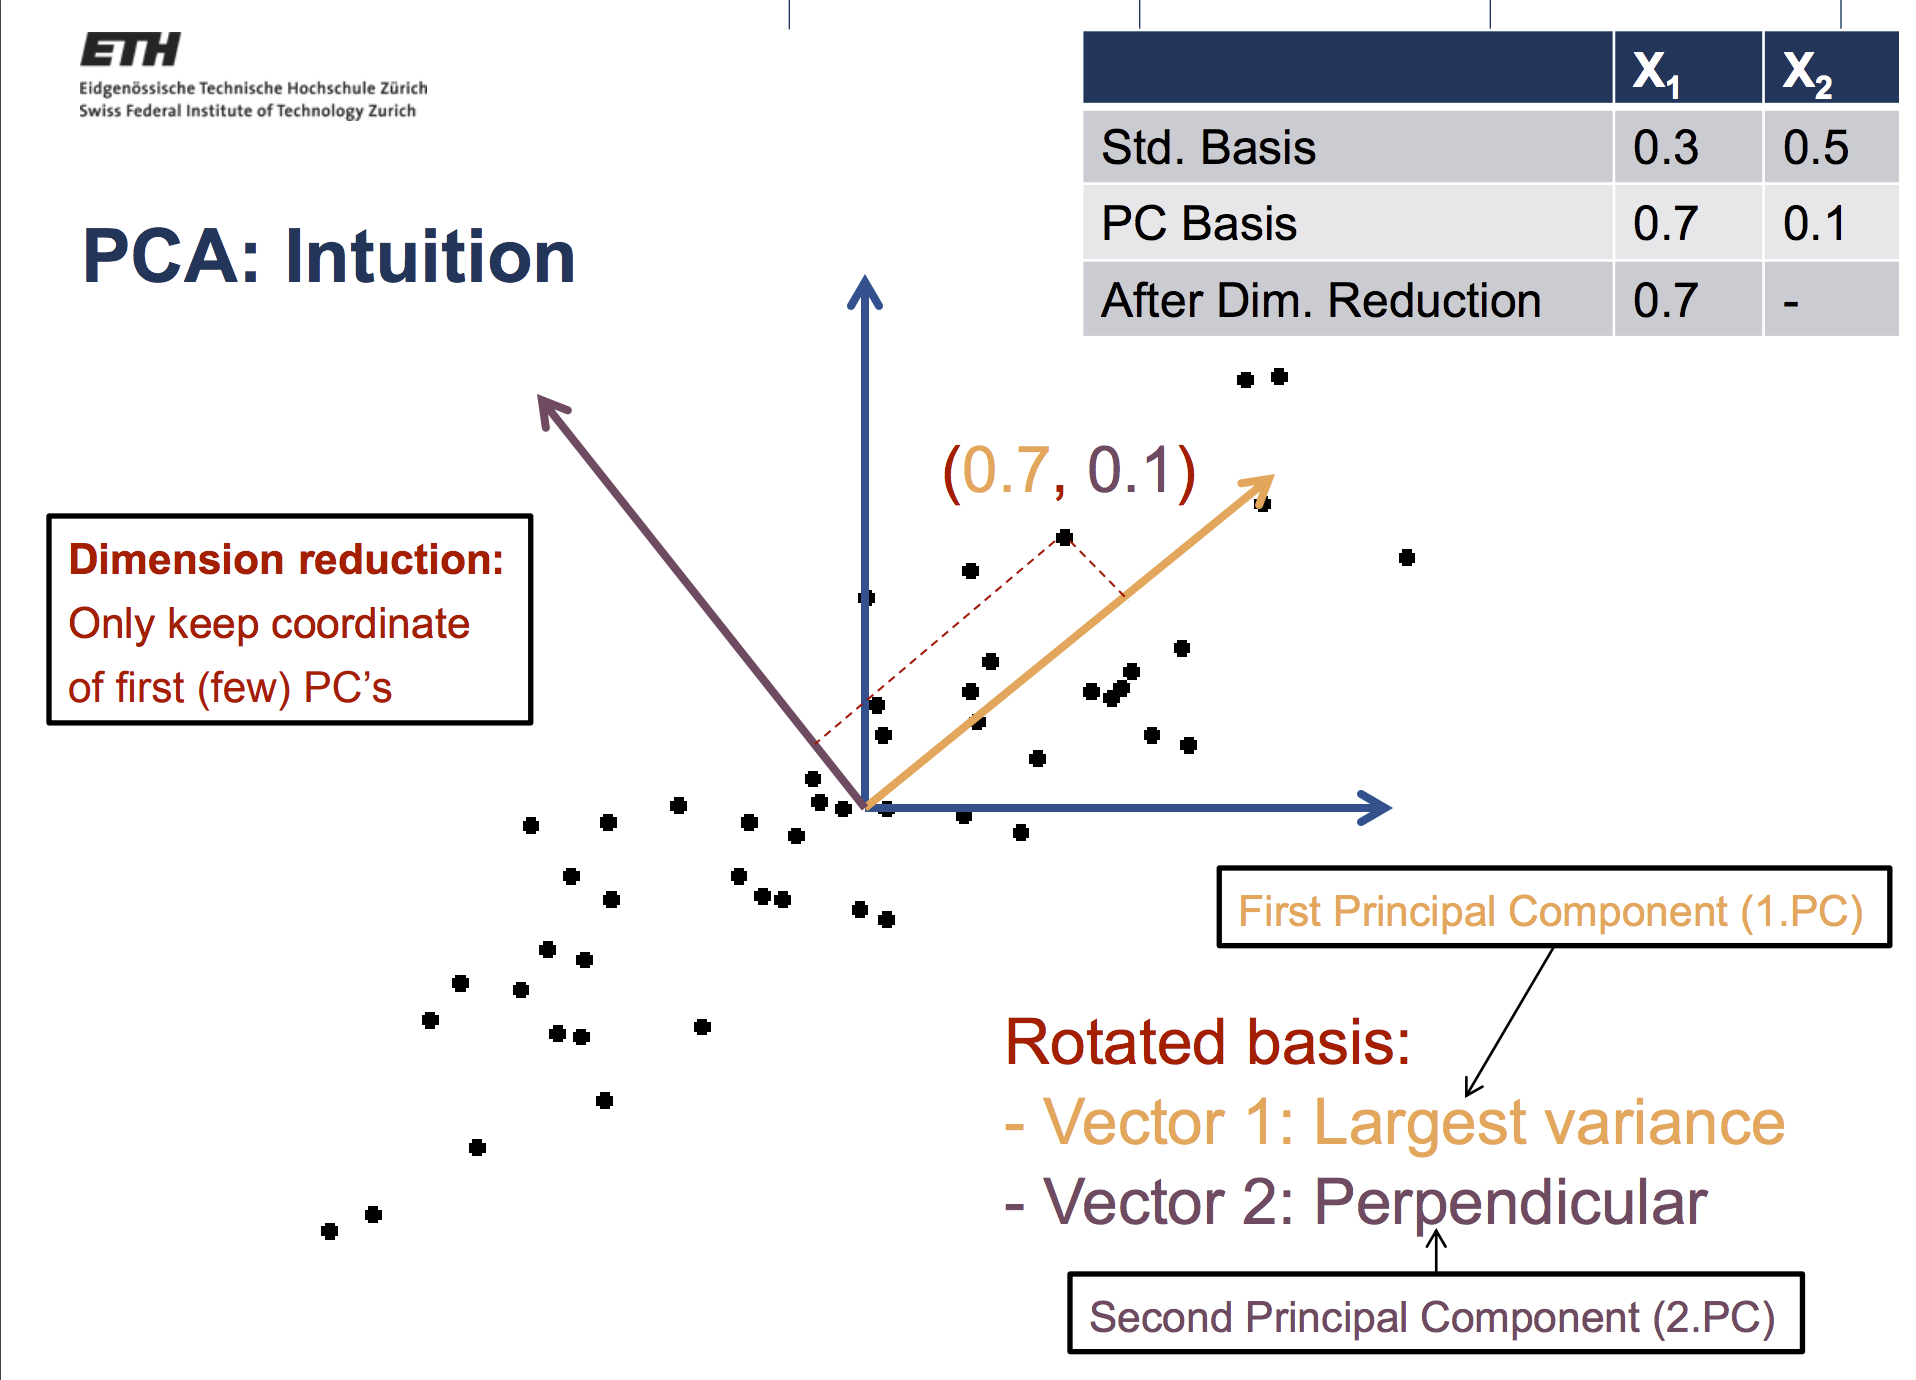

Source: https://stat.ethz.ch/education/semesters/ss2012/ams/slides/v5.pdf

# Key concepts of PCA

* Measures how each variable is associated with one another using a covariance matrix

* Understands the directions of the spread of our data using Eigenvectors

* Brings out the relative importance of these directions using Eigenvalues

Source: https://blog.clairvoyantsoft.com/eigen-decomposition-and-pca-c50f4ca15501

# Computing Principal Components: Under the hood

In [13]:
#Let's initialize some data
#Define mu vector
mu = np.array([1.0,0.1])
#Define covariance matrix
Sigma = np.array([[2.0,1.0],[1.0,5.0]])
np.random.seed(1)
X = np.random.multivariate_normal(mu,Sigma,1000)

In [14]:
#Center your data by subtracting the means
X = X - np.mean(X,axis=0)
print(np.mean(X,axis=0))

[-8.79296636e-16 -9.39248679e-17]


In [15]:
#Transpose data to ensure shape is consistent with our definition of the sample covariance matrix
X = X.T

In [16]:
#Calculate the covariance matrix of our data
Q = 1/(X.shape[1]-1)*np.matmul(X,X.T)

In [17]:
#Perform eigendecomposition of the sample covariance matrix
(eigenvalues_unsorted,eigenvectors_unsorted) = np.linalg.eig(Q)

In [18]:
#Sort the eigenvalues (and related eigenvectors) from highest to lowest
argsort = np.argsort(eigenvalues_unsorted)[::-1]
eigenvalues = eigenvalues_unsorted[argsort]
eigenvectors = eigenvectors_unsorted[:,argsort]
print('Eigenvalues:')
print(eigenvalues)
print('Eigenvectors:')
print(eigenvectors)

Eigenvalues:
[5.40073791 1.70649547]
Eigenvectors:
[[-0.26001465 -0.96560467]
 [-0.96560467  0.26001465]]


# Let's plot the eigenvectors

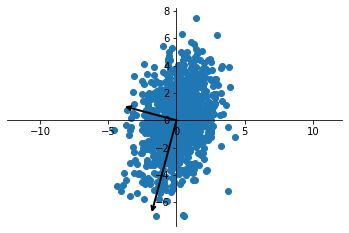

In [19]:
def draw_vector(v0, v1):
    ax = plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X.T[:, 0], X.T[:, 1])#, alpha=0.2)
for length, vector in zip(eigenvalues, eigenvectors):
    v = vector * 3 * np.sqrt(length)
    draw_vector(np.zeros(2),v)
    ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal');

The eigenvectors define the direction of our principal components

# Use eigenvectors to transform our data to the PC space

In [20]:
#Transform our data from its original basis to the new orthogonal basis
y1 = eigenvectors[0,0]*X[0,:] + eigenvectors[1,0]*X[1,:]
y2 = eigenvectors[0,1]*X[0,:] + eigenvectors[1,1]*X[1,:]

In [21]:
#We can actually just compute y1 and y2 as a single linear operation
Y = np.matmul(eigenvectors,X).T

**Note**: The columns of Y are principal component 1 and principal component 2 respectively.

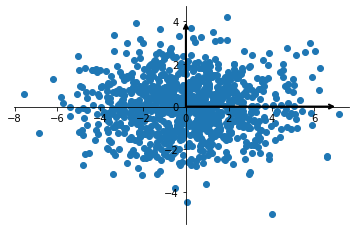

In [22]:
def draw_vector(v0, v1, ax=None):
    ax = plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
plt.scatter(Y[:,0],Y[:,1])
for i in range(eigenvalues.size):
    if i == 0:v = (3 * np.sqrt(eigenvalues[i]),0)
    if i == 1:v = (0,3 * np.sqrt(eigenvalues[i]))
    draw_vector(np.zeros(2),v)
    ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal');
plt.show()

Let's look at some properties of the two principal components

# Linear correlation

In [23]:
#Linear correlation
import scipy.stats
print('Pearson correlation:')
print(scipy.stats.pearsonr(Y[:,0],Y[:,1])[0])

Pearson correlation:
1.0408340855860843e-17


# Covariance matrix

In [24]:
#Covariance matrix
print('Covariance matrix:')
Q = np.cov(Y.T)
print(Q)

Covariance matrix:
[[5.40073791e+00 4.26752394e-17]
 [4.26752394e-17 1.70649547e+00]]


In [25]:
#Diagnonal of the covariance matrix
print(np.diag(Q))

[5.40073791 1.70649547]


Haven't we seen this before?

In [26]:
#Diagnonal of the covariance matrix
print(np.diag(Q))

[5.40073791 1.70649547]


In [27]:
#Computed eigenvalues
print(eigenvalues)

[5.40073791 1.70649547]


**Key interpretation**: The eigenvalues of the eigendecomposition performed on the original covariance matrix are the variances of the principal components. These sorted eigenvalues are commonly referred to as explained variance.

# "Conservation of total variance"

In [28]:
print('Total variance of X')
print(np.var(X.T[:,0]) + np.var(X.T[:,1]))
print('Total variance of Y')
print(np.var(Y[:,0]) + np.var(Y[:,1]))

Total variance of X
7.100126147726278
Total variance of Y
7.100126147726279


We maintain the original information, it has just been reprojected to a different basis. 

# Projecting back to our original basis

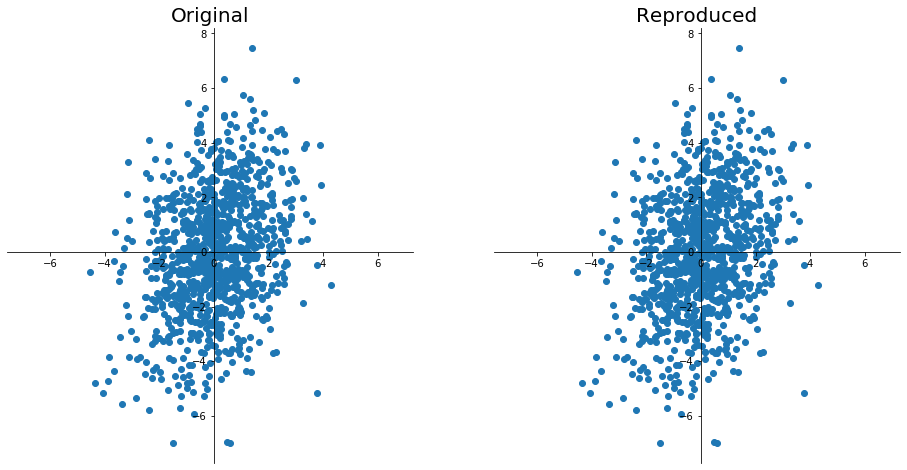

In [29]:
Xpred = np.matmul(eigenvectors,Y.T)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Original',fontsize=20)
plt.scatter(X[0,:],X[1,:])
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal');
plt.subplot(122)
plt.title('Reproduced',fontsize=20)
plt.scatter(Xpred[0,:],Xpred[1,:])
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.axis('equal');
plt.show()

Transforming the data is simply a linear transformation that can be inverted. The only time that we "lose" information is when we throw out principal components (i.e., reduce dimensions).

# Using PCA for dimensionality reduction

* One of the primary roles of PCA is to throw out dimensions that do not play a large role in the total variance.

* This is done by simply throwing out principal components (PCs) that have a relatively small variance when compared to other PCs. 

Let's show this via example:

In [30]:
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=1)
#Fit the model
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
print('Explained variance')
print(pca.explained_variance_)

Explained variance
[5.40073791]


In [32]:
print("Let's transform our data to the reduced space")
Y = pca.transform(X.T)
print(Y.shape)

Let's transform our data to the reduced space
(1000, 1)


## Reproject our data back to the original basis

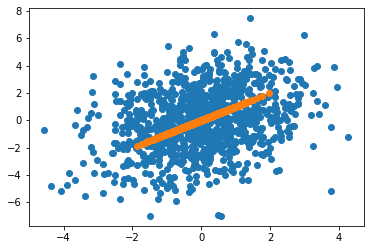

In [33]:
#Let's reproject our data back to the original basis now
Xpred = pca.inverse_transform(Y)
plt.scatter(X[0,:],X[1,:])
plt.scatter(Xpred[:,0],Xpred[:,0])

What just happened?

# Key concepts of PCA

* Measures how each variable is associated with one another using a covariance matrix

* Understands the directions of the spread of our data using Eigenvectors

* Brings out the relative importance of these directions using Eigenvalues

Source: https://blog.clairvoyantsoft.com/eigen-decomposition-and-pca-c50f4ca15501

Now that we have some intuition on PCA, let's take it to our spatial data now

In [36]:
#Import data
import rasterio
import numpy as np
data = {}
file = '../Workspace/dem.tif'
data['dem'] = rasterio.open(file).read(1)
file = '../Workspace/ppt.tif'
data['ppt'] = rasterio.open(file).read(1)
file = '../Workspace/tmean.tif'
data['tmean'] = rasterio.open(file).read(1)
file = '../Workspace/treecover.tif'
data['tcf'] = rasterio.open(file).read(1)
file = '../Workspace/barecover.tif'
data['bcf'] = rasterio.open(file).read(1)
file = '../Workspace/sand.tif'
data['sand'] = rasterio.open(file).read(1)
#Create lats/lons arrays
fp = rasterio.open(file)
lons = np.linspace(fp.bounds.left+fp.res[0]/2,fp.bounds.right-fp.res[0]/2,data['sand'].shape[1])
lats = np.linspace(fp.bounds.bottom+fp.res[1]/2,fp.bounds.top-fp.res[1]/2,data['sand'].shape[0])
(lons,lats) = np.meshgrid(lons,lats)
#(lons,lats) = np.meshgrid(lats,lons)
data['lon'] = lons[:]
data['lat'] = np.flipud(lats[:])

# Back to our dove example

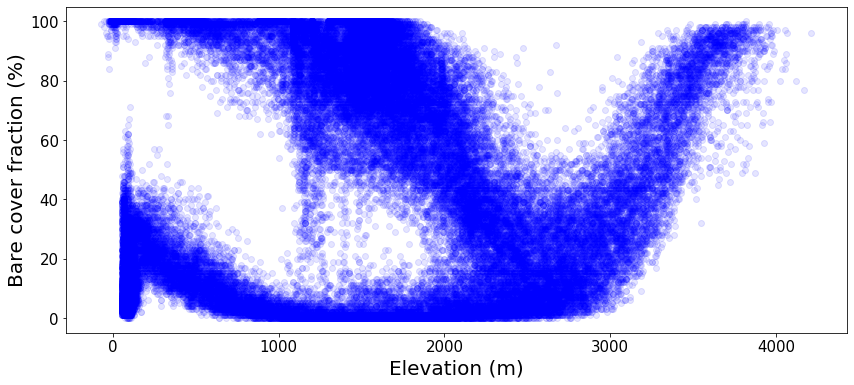

In [37]:
plt.figure(figsize=(14,6))
plt.plot(data['dem'],data['bcf'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

# Let's apply PCA to our dove

In [38]:
import sklearn.decomposition
#Define X
X = np.stack((data['dem'].reshape(data['dem'].size),data['bcf'].reshape(data['bcf'].size))).T
#Let's standardize X
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=2)
#Fit the model
pca.fit(X)
#Print the explained variances
print(pca.explained_variance_)

[1.104565  0.8954683]


What does this mean?

# Let's try another example

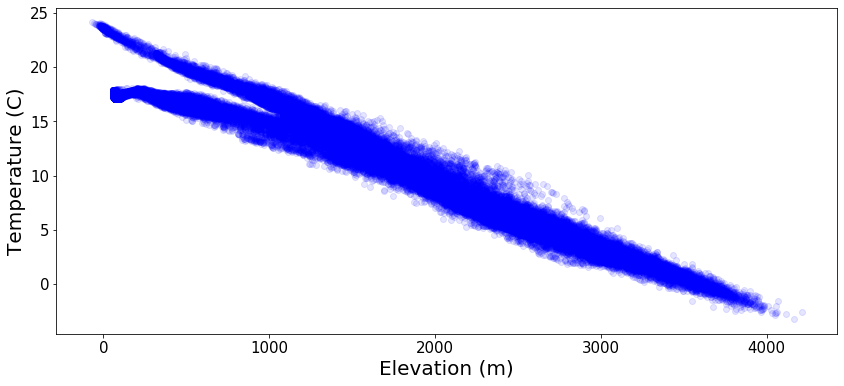

In [40]:
plt.figure(figsize=(14,6))
plt.plot(data['dem'],data['tmean'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Temperature (C)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

# Apply PCA

In [41]:
import sklearn.decomposition
#Define X
X = np.stack((data['dem'].reshape(data['dem'].size),data['tmean'].reshape(data['tmean'].size))).T
#Let's standardize X
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=2)
#Fit the model
pca.fit(X)
#Print the explained variances
print(pca.explained_variance_)

[1.9619814  0.03805172]


What does this mean?

# Let's throw out the second PC and reproduce the original data

In [42]:
#Define X
X = np.stack((data['dem'].reshape(data['dem'].size),data['tmean'].reshape(data['tmean'].size))).T
#Let's standardize X
X_std = (X - np.mean(X,axis=0))/np.std(X,axis=0)
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=1)
#Fit the model
pca.fit(X_std)
#Transform the data
Y = pca.transform(X_std)
#Inverse transform the data
Xpred_std = pca.inverse_transform(Y)
#"Destandardize"
Xpred = Xpred_std*np.std(X,axis=0) + np.mean(X,axis=0)

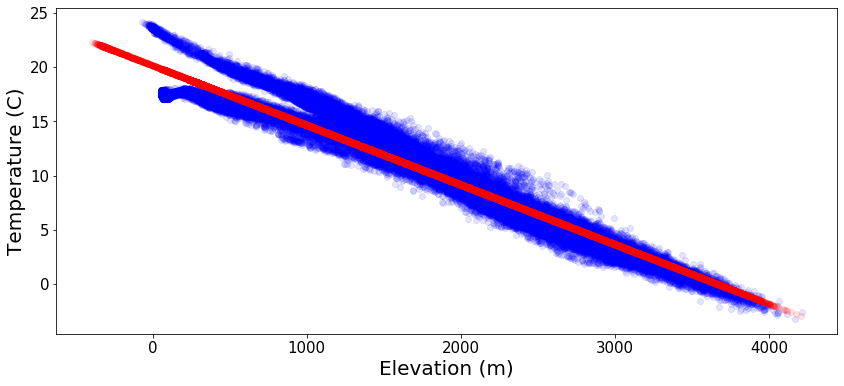

In [43]:
plt.figure(figsize=(14,6))
plt.plot(X[:,0],X[:,1],'bo',alpha=0.1)
plt.plot(Xpred[:,0],Xpred[:,1],'ro',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Temperature (C)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

# Let's compare the maps

In [44]:
#Reshape to arrays
dem_pred = Xpred[:,0].reshape(data['dem'].shape)
tmean_pred = Xpred[:,1].reshape(data['tmean'].shape)

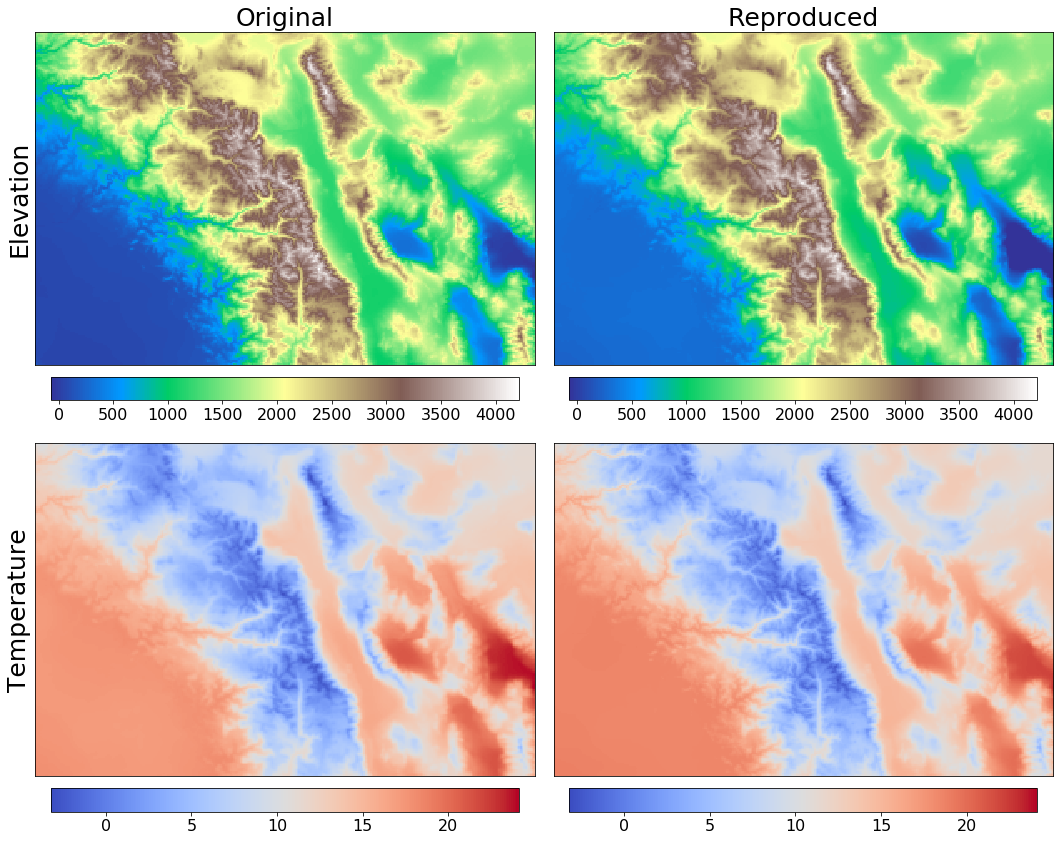

In [45]:
#Create a figure comparing them
#Compare the two
vmin = np.min(data['dem'])
vmax = np.max(data['dem'])
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(data['dem'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(data['tmean'])
vmax = np.max(data['tmean'])
plt.subplot(223)
plt.imshow(data['tmean'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('coolwarm'))
plt.ylabel('Temperature',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(tmean_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('coolwarm'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

# Let's apply this to the 8 dimensions

In [46]:
#Bring in the data
X = []
for var in data:
    tmp = data[var].reshape(data[var].size)
    X.append(tmp)
X = np.array(X).T
#Standardize the data
X_std = (X - np.mean(X,axis=0))/np.std(X,axis=0)

In [47]:
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=8)
#Fit the model
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

# Let's look at the explained variance 

[2.9836987  2.50019009 0.86323273 0.79610885 0.5078018  0.24870686
 0.09028138 0.01011291]


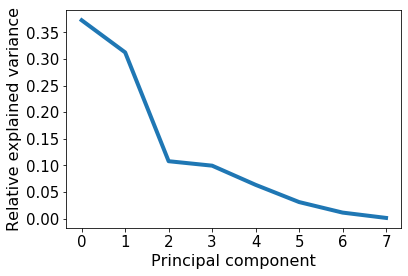

In [48]:
print(pca.explained_variance_)
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),lw=4)
plt.ylabel('Relative explained variance',fontsize=16)
plt.xlabel('Principal component',fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Let's throw everything out except for the first 3 PCs

In [49]:
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=3)
#Fit the model
pca.fit(X_std)
#Transform the data
Y = pca.transform(X_std)
#Inverse transform the data
Xpred_std = pca.inverse_transform(Y)
#"Destandardize"
Xpred = Xpred_std*np.std(X,axis=0) + np.mean(X,axis=0)

dem
ppt
tmean
tcf
bcf
sand
lon
lat


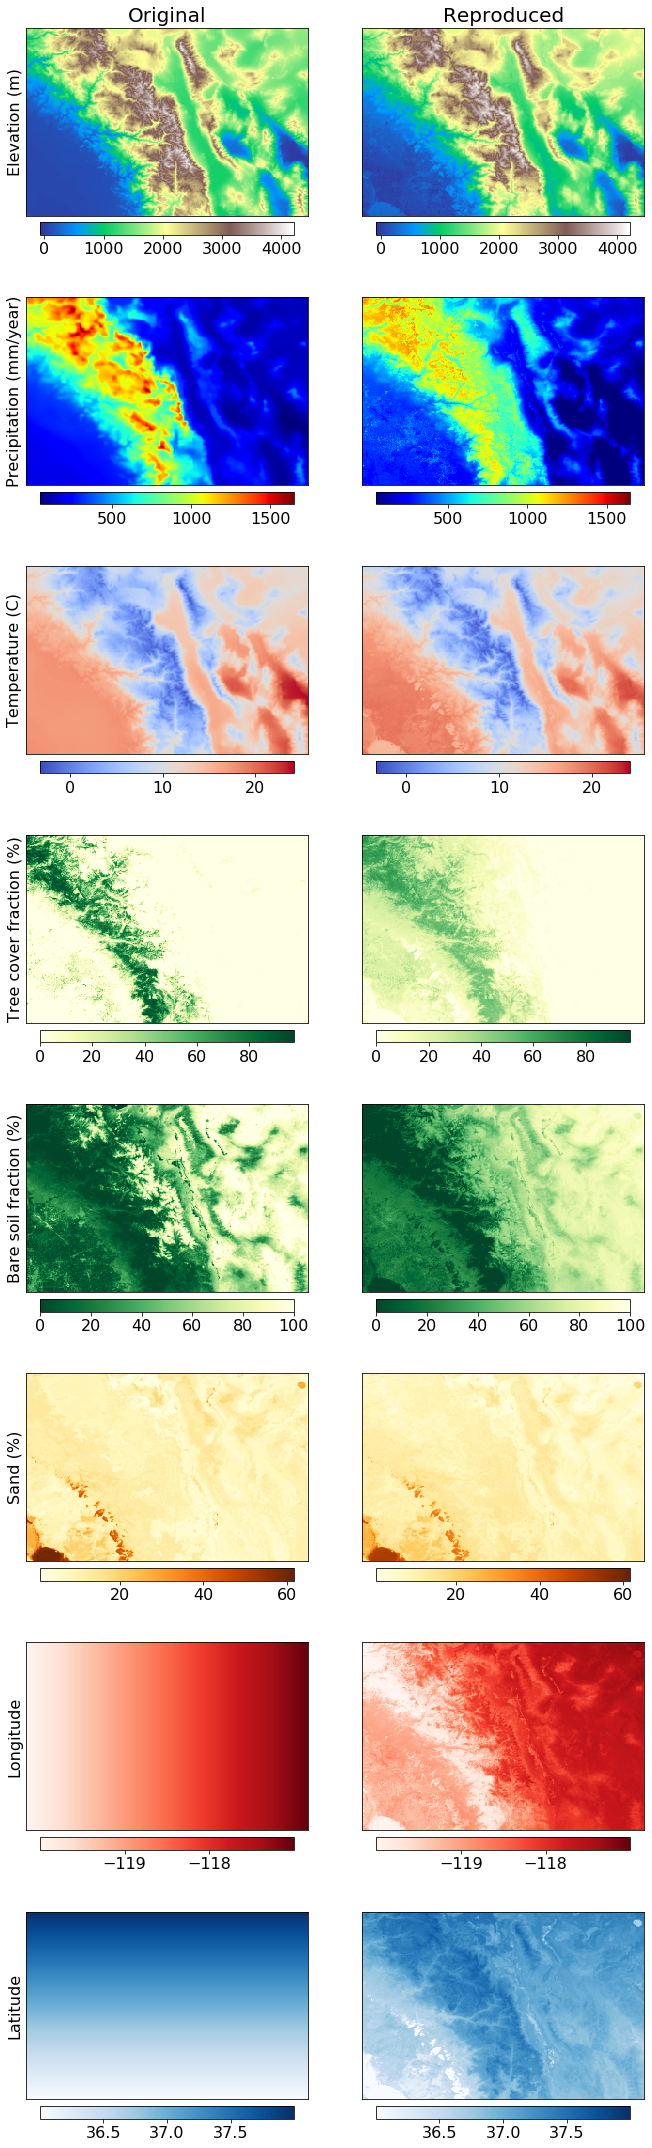

In [50]:
info = {'dem':{'cmap':'terrain','title':'Elevation (m)'},
        'ppt':{'cmap':'jet','title':'Precipitation (mm/year)'},
        'sand':{'cmap':'YlOrBr','title':'Sand (%)'},
        'tcf':{'cmap':'YlGn','title':'Tree cover fraction (%)'},
        'bcf':{'cmap':'YlGn_r','title':'Bare soil fraction (%)'},
        'tmean':{'cmap':'coolwarm','title':'Temperature (C)'},
        'lat':{'cmap':'Blues','title':'Latitude'},
        'lon':{'cmap':'Reds','title':'Longitude'}}
#Reproduce the data
data_pred = {}
i = 0
for var in data:
    data_pred[var] = Xpred[:,i].reshape(data[var].shape)
    i += 1
#Create a figure comparing them
i = 0
plt.figure(figsize=(10,30))
for var in data:
    print(var)
    vmin = np.min(data[var])
    vmax = np.max(data[var])
    i += 1
    plt.subplot(8,2,i)
    plt.imshow(data[var],vmin=vmin,vmax=vmax,cmap=plt.get_cmap(info[var]['cmap']))
    plt.ylabel(info[var]['title'],fontsize=16)
    if i == 1:plt.title('Original',fontsize=20)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.70)
    cb.ax.tick_params(labelsize=16)
    i += 1
    plt.subplot(8,2,i)
    if i == 2:plt.title('Reproduced',fontsize=20)
    plt.imshow(data_pred[var],vmin=vmin,vmax=vmax,cmap=plt.get_cmap(info[var]['cmap']))
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.70)
    cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

# What if we keep the first 6 PCs?

In [51]:
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=6)
#Fit the model
pca.fit(X_std)
#Transform the data
Y = pca.transform(X_std)
#Inverse transform the data
Xpred_std = pca.inverse_transform(Y)
#"Destandardize"
Xpred = Xpred_std*np.std(X,axis=0) + np.mean(X,axis=0)

dem
ppt
tmean
tcf
bcf
sand
lon
lat


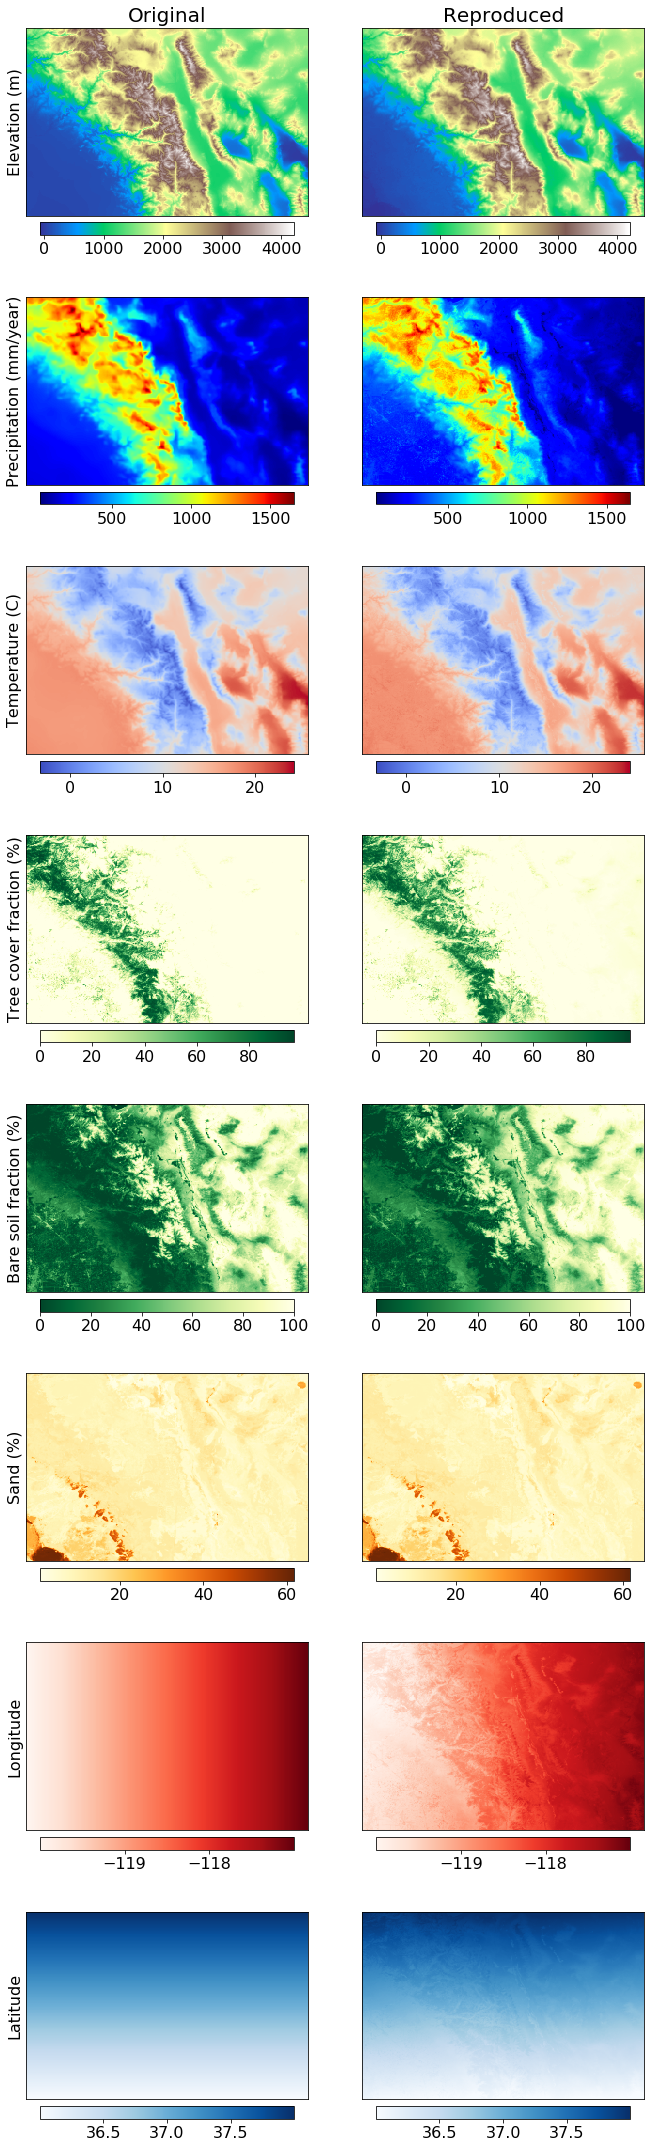

In [52]:
#Reproduce the data
data_pred = {}
i = 0
for var in data:
    data_pred[var] = Xpred[:,i].reshape(data[var].shape)
    i += 1
#Create a figure comparing them
i = 0
plt.figure(figsize=(10,30))
for var in data:
    print(var)
    vmin = np.min(data[var])
    vmax = np.max(data[var])
    i += 1
    plt.subplot(8,2,i)
    plt.imshow(data[var],vmin=vmin,vmax=vmax,cmap=plt.get_cmap(info[var]['cmap']))
    plt.ylabel(info[var]['title'],fontsize=16)
    if i == 1:plt.title('Original',fontsize=20)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.70)
    cb.ax.tick_params(labelsize=16)
    i += 1
    plt.subplot(8,2,i)
    if i == 2:plt.title('Reproduced',fontsize=20)
    plt.imshow(data_pred[var],vmin=vmin,vmax=vmax,cmap=plt.get_cmap(info[var]['cmap']))
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.70)
    cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

# PCA applications

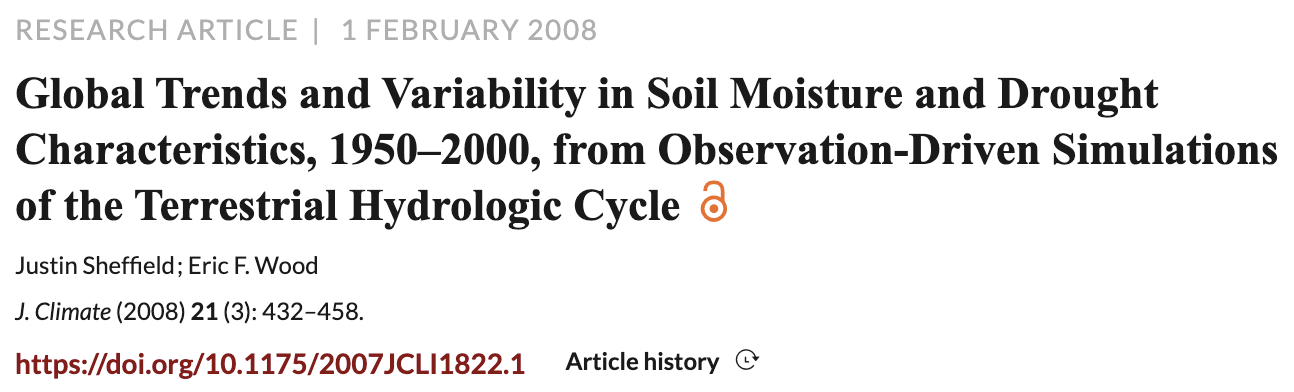

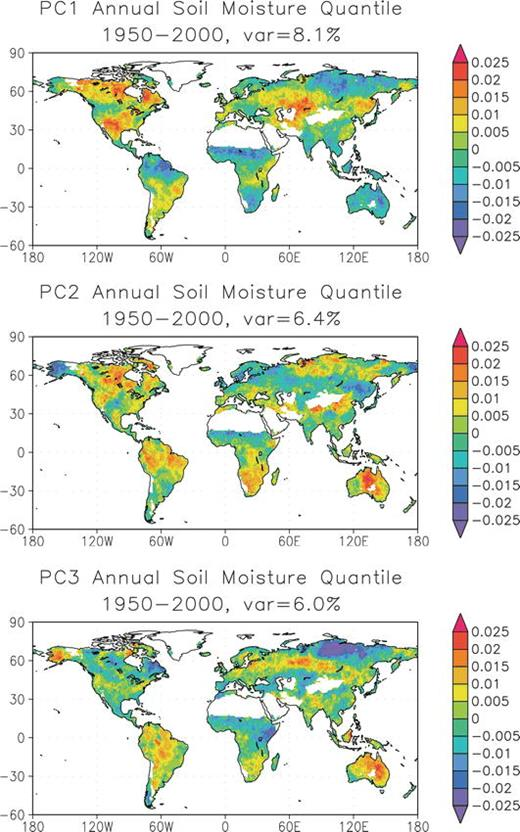

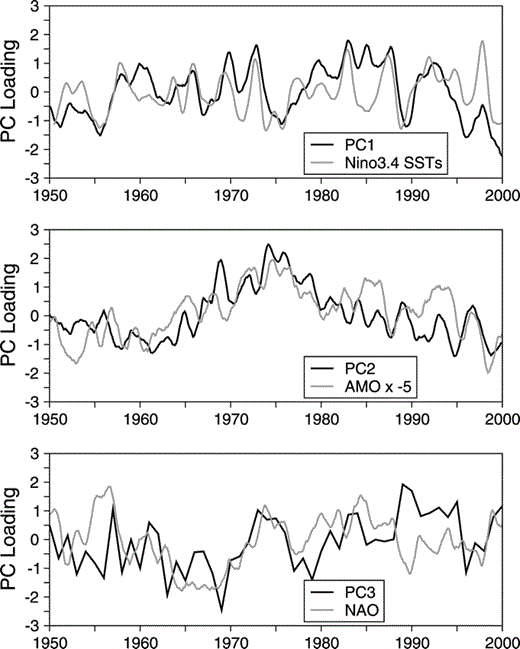

# Other dimensionality reduction techniques

* Independent Component Analysis
* Kernel PCA
* Canonical correlation analysis